In [117]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.Simulate import simulate_parallel

In [118]:
c = 299792458

# Create a reference pulse
def simulate_reference(L, deltat):
    toff = 1.0e-11
    twidth = 8.0e-13
    tdecay = 1.0e-12
    scale = 1.0e12

    t = torch.arange(0, L, dtype=torch.float32) * deltat - toff
    x = -scale * t * torch.exp(-(t / twidth) ** 2 - t / tdecay)

    return x


def rts_batched(n0, nj, Dj):
    # All inputs are shape [F]
    c = torch.cos(nj * Dj)
    s = torch.sin(nj * Dj)
    d = c + (0.5j) * (nj / n0 + n0 / nj) * s
    r = (0.5j) * s * (n0 / nj - nj / n0) / d
    t = 1.0 / d
    return r, t * torch.exp(1j * n0 * Dj), t * t - r * r




def RTm_batched(m, n0, layers):
    # Each entry in layers is a tuple of shape [F] tensors: (nj, Dj)
    F = layers[0][0].shape[0]

    U = torch.zeros(F, dtype=torch.cfloat, device=n0.device)
    V = torch.ones(F, dtype=torch.cfloat, device=n0.device)
    T = torch.ones(F, dtype=torch.cfloat, device=n0.device)

    for j in range(m):
        nj, Dj = layers[j]
        r, t, s = rts_batched(n0, nj, Dj)

        Vlast = V.clone()
        U_new = r * V + s * U
        V_new = V - r * U
        U, V = U_new, V_new

        T = T * t * Vlast / V

    R = U / V
    return R, T

In [119]:
def preprocess_pulse(
    filename,
    target_length=4096,
    #window_size=600,
    normalize=True,
    device="cpu"
):
    """
    Preprocess an experimental THz-TDS pulse:
      - loads data from text
      - removes DC offset
      - crops main pulse region
      - normalizes amplitude (optional)
      - zero-pads or trims to target_length
      - returns torch.float32 tensor on requested device
    """

    # ---------- Load ----------
    x = np.loadtxt(filename, dtype=float)
    x = torch.tensor(x, dtype=torch.float32, device=device)
    t1, amp1 = x[:,0], x[:,1]

    # ---------- Remove DC ----------
    amp1 = amp1 - amp1.mean()

    # ---------- Find Main Pulse ----------
    #peak = torch.argmax(torch.abs(x))
    #half = window_size // 2
    #start = max(0, int(peak - half))
    #end   = min(len(x), int(peak + half))

    #x = x[start:end]

    # ---------- Normalize (optional) ----------
    if normalize:
        maxval = torch.max(torch.abs(x))
        if maxval > 0:
            x = x / maxval

    # ---------- Pad or Trim ----------
    L = len(x)

    if L < target_length:
        pad_amount = target_length - L
        x = torch.nn.functional.pad(x, (0, pad_amount))
    else:
        x = x[:target_length]

    return x
# Load + preprocess both pulses

reference_pulse = preprocess_pulse("reference.txt")
sample_pulse    = preprocess_pulse("Black_5mm.txt")

def normalise_pulses(ref_amp, sam_amp):
    ref_max = torch.max(torch.abs(ref_amp))
    if ref_max == 0:
        raise ValueError("Reference pulse contains no amplitude (all zeros).")
        
    if torch.max(torch.abs(ref_amp)) < torch.max(torch.abs(sam_amp)):
        print("Reference pulse amplitude smaller than sample pulse.")
    ref_amp_norm = ref_amp / torch.max(torch.abs(ref_amp))
    sam_amp_norm = sam_amp / torch.max(torch.abs(ref_amp))
    return ref_amp_norm, sam_amp_norm

def align_and_pad(time_ref, time_sam, amp_ref, amp_sam, final_length):
    """
    Aligns two THz time-domain signals by padding the earlier one
    so that both start at the same time, and pads both to 'final_length'.

    Parameters
    ----------
    time_ref : np.array
        Time axis of reference waveform.
    time_sam : np.array
        Time axis of sample waveform.
    amp_ref : np.array
        Reference amplitude waveform.
    amp_sam : np.array
        Sample amplitude waveform.
    final_length : int
        Desired final padded length (e.g., 4096).

    Returns
    -------
    time_padded : np.array
        Common time axis after alignment and padding.
    amp_ref_padded : np.array
        Zero-padded reference amplitude.
    amp_sam_padded : np.array
        Zero-padded sample amplitude.
    time_step : float
        Sampling interval dt.
    """

    # --- Determine dt ---
    time_step_ref = time_ref[1] - time_ref[0]
    time_step_sam = time_sam[1] - time_sam[0]
    print(time_step_ref-time_step_sam)
    #if not np.isclose(time_step_ref, time_step_sam, rtol=1e-2):
      #  raise ValueError("Reference and sample must have the same time step.")

    dt = time_step_ref

    # --- Compute alignment padding ---
    start_ref = time_ref[0]
    start_sam = time_sam[0]

      # Compute padding lengths
    if start_ref < start_sam:
        pad_ref = 0
        pad_sam = int(torch.round((start_sam - start_ref) / dt).item())
    else:
        pad_ref = int(torch.round((start_ref - start_sam) / dt).item())
        pad_sam = 0

    # Apply padding
    amp_ref_aligned = torch.nn.functional.pad(amp_ref, (pad_ref, 0))
    amp_sam_aligned = torch.nn.functional.pad(amp_sam, (pad_sam, 0))

    # Pad both to final_length
    amp_ref_padded = torch.nn.functional.pad(amp_ref_aligned, (0, max(0, final_length - amp_ref_aligned.shape[0])))
    amp_sam_padded = torch.nn.functional.pad(amp_sam_aligned, (0, max(0, final_length - amp_sam_aligned.shape[0])))

    amp_ref_padded = amp_ref_padded[:final_length]
    amp_sam_padded = amp_sam_padded[:final_length]

    # Build common time axis as tensor
    earliest_start = min(start_ref, start_sam)
    time_padded = torch.arange(final_length, dtype=dt.dtype, device=dt.device) * dt
    

    return time_padded, amp_ref_padded, amp_sam_padded, dt


        


In [120]:
len(reference_pulse)

2425

In [121]:
# ---------- Load ----------
ref = np.loadtxt("reference.txt", dtype=float)
ref = torch.tensor(ref, dtype=torch.float32, device="cpu")
sam = np.loadtxt("Black_5mm.txt", dtype=float)
sam = torch.tensor(sam, dtype=torch.float32, device="cpu")

In [122]:
t1, amp1 = ref[:,0], ref[:,1]
t2, amp2 = sam[:,0], sam[:,1]
amp1 = amp1 - amp1.mean()
amp2 = amp2 - amp2.mean()
print(amp1.mean())
print(amp2.mean())

tensor(9.0636e-11)
tensor(3.0791e-10)


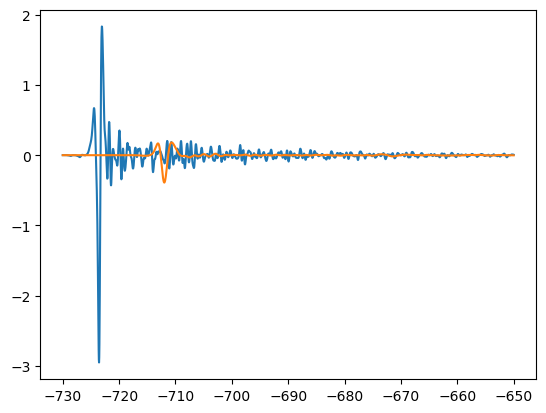

In [123]:
plt.plot(t1,amp1)
plt.plot(t2,amp2)

In [124]:
# Normalise



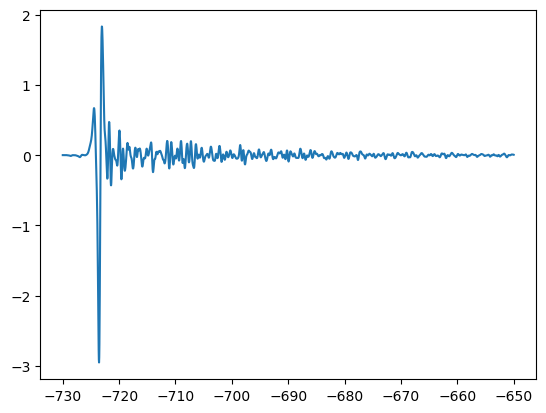

In [125]:
plt.plot(t1,amp1)

In [126]:
ref_amp, sam_amp = normalise_pulses(amp1, amp2)

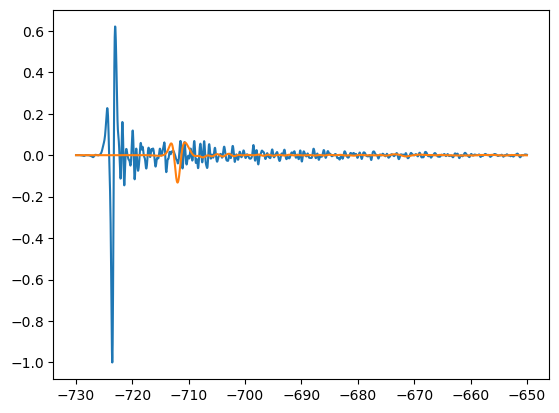

In [127]:
plt.plot(t1,ref_amp)
plt.plot(t2,sam_amp)

In [128]:
tAxis, ref_amp, sam_amp, timeStep = align_and_pad(t1,t2,ref_amp,sam_amp,4096)

tensor(0.)


In [129]:
test = t1[1] - t1[0]
test2 = t2[1] - t2[0]
print(test)
print(test2)

tensor(0.0330)
tensor(0.0330)


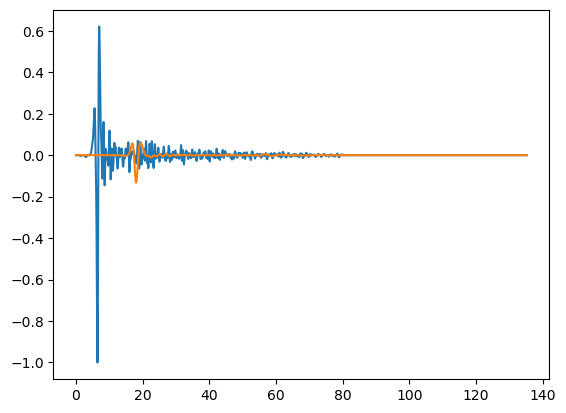

In [130]:
plt.plot(tAxis,ref_amp)
plt.plot(tAxis,sam_amp)

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (1.6, 2.0)
Layer 1 - k ∈ (-0.015, -0.005)
[((1.70625951835214-0.015j), 0.005)]


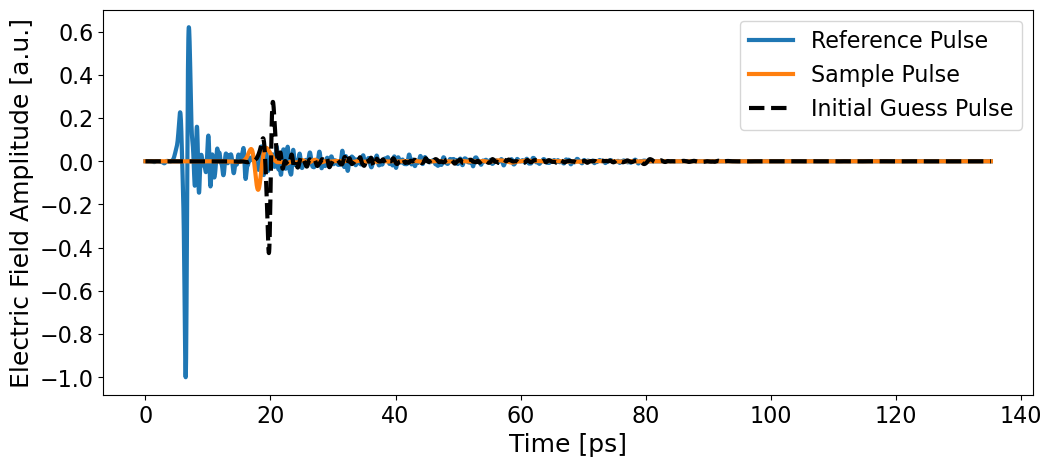

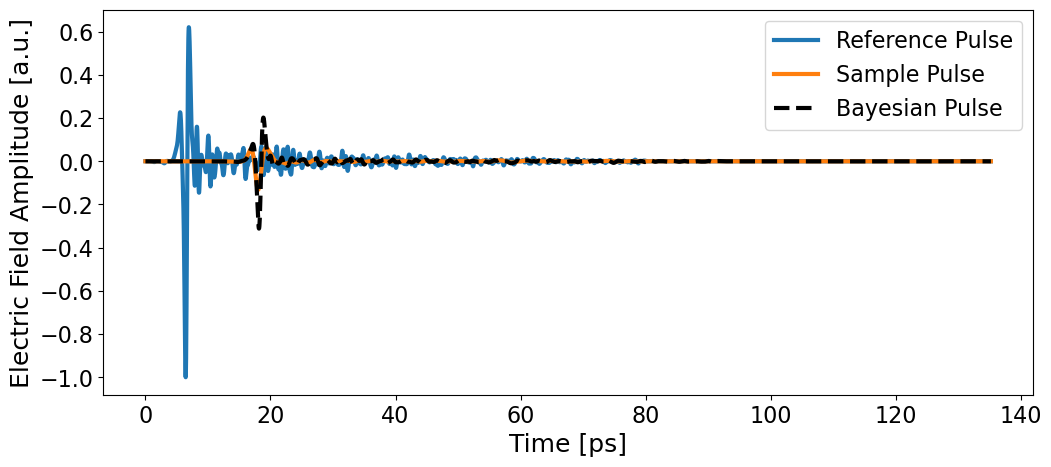

In [131]:
## Experimental params:
n1, k1, d1 = 3, 0.01, 5e-3
# n2, k2, d2= 2.5, 0.015, 0.2e-3
deltat = 0.0330e-12
c = 3e8
L = 2**12  # Number of time points
optimize_mask = [
    (True, True, False),     
]

optimization_bounds = [0.2, 0.005, 0.1e-3]

layers_init = [(1.8-0.01*1j, 5e-3)]
#layers_init = [(torch.tensor(2-0.01j, dtype=torch.cfloat), torch.tensor(1e-3, dtype=torch.cfloat)),]


intial_pulse = simulate_parallel(ref_amp, layers_init, deltat, 0)[1][:L]
#T_exp, y_exp = simulate_from_signal(ref_amp, layers_init, deltat)


BLE_NK = BayesianLayeredExtractor(ref_amp, sam_amp, deltat, layers_init, optimize_mask=optimize_mask, optimization_bounds=optimization_bounds)
bayesian_params = BLE_NK.bayesian_optimization(n_calls=30)
print(bayesian_params)

_, bayesian_pulse = simulate_parallel(ref_amp, bayesian_params, deltat, noise_level=0)
bayesian_pulse = bayesian_pulse[:L]



plt.figure(figsize=(12,5))
plt.plot(tAxis, ref_amp, label='Reference Pulse', linewidth='3')
plt.plot(tAxis, sam_amp, label='Sample Pulse', linewidth='3')
plt.plot(tAxis, intial_pulse.detach().cpu().numpy(), label='Initial Guess Pulse', linestyle='--', color='k', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [a.u.]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()



plt.figure(figsize=(12,5))
plt.plot(tAxis, ref_amp, label='Reference Pulse', linewidth='3')
plt.plot(tAxis, sam_amp, label='Sample Pulse', linewidth='3')
plt.plot(tAxis, bayesian_pulse.detach().cpu().numpy(), label='Bayesian Pulse', linestyle='--', color='k', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [a.u.]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

Optimizing n and k with initial conditions [((1.8-0.01j), 0.005)]
Fine-tuning 2 parameters for 3000 iterations.
Iteration 99, Loss: 3.955245e-03, Layer 0: n=1.7079, k=-0.03293, D=5000.00 µm
Iteration 199, Loss: 3.954857e-03, Layer 0: n=1.7079, k=-0.03281, D=5000.00 µm
Iteration 299, Loss: 3.954857e-03, Layer 0: n=1.7079, k=-0.03281, D=5000.00 µm
Iteration 399, Loss: 3.954857e-03, Layer 0: n=1.7079, k=-0.03281, D=5000.00 µm
Iteration 499, Loss: 3.954857e-03, Layer 0: n=1.7079, k=-0.03281, D=5000.00 µm
Iteration 599, Loss: 3.954857e-03, Layer 0: n=1.7079, k=-0.03281, D=5000.00 µm
Iteration 699, Loss: 3.954857e-03, Layer 0: n=1.7079, k=-0.03281, D=5000.00 µm
Iteration 799, Loss: 3.954857e-03, Layer 0: n=1.7079, k=-0.03281, D=5000.00 µm
Iteration 899, Loss: 3.954857e-03, Layer 0: n=1.7079, k=-0.03281, D=5000.00 µm
Iteration 999, Loss: 3.954857e-03, Layer 0: n=1.7079, k=-0.03281, D=5000.00 µm
Iteration 1099, Loss: 3.954857e-03, Layer 0: n=1.7079, k=-0.03281, D=5000.00 µm
Iteration 1199, Los

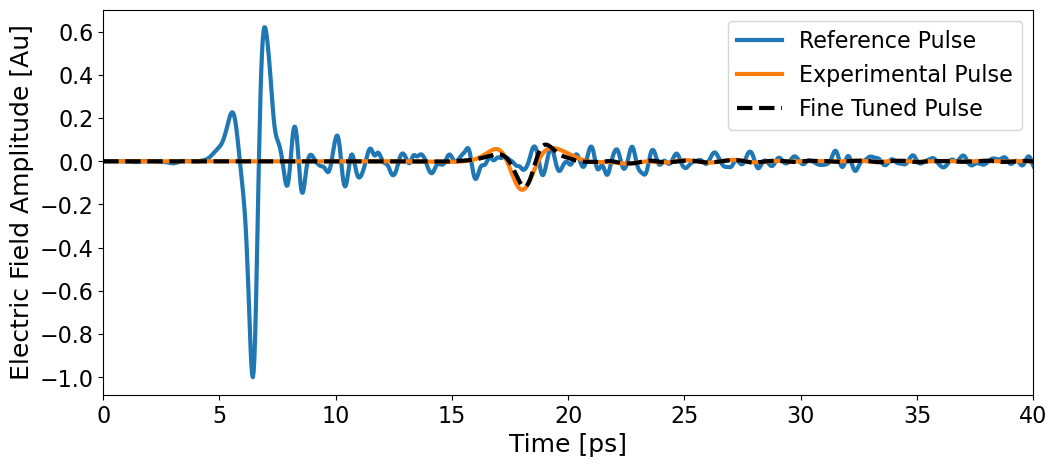

In [132]:
alpha = 1
LE_nk = LayeredExtractor(ref_amp, sam_amp, deltat, bayesian_params, lr=0.001, optimize_mask=optimize_mask)
print(f'Optimizing n and k with initial conditions {layers_init}')
optim_params = LE_nk.optimize(num_iterations=3000, updates=100, alpha=alpha)



_, optimal_pulse_nk = simulate_parallel(ref_amp, optim_params, deltat, noise_level=0)
optimal_pulse_nk = optimal_pulse_nk[:L]

print(optim_params)
plt.figure(figsize=(12,5))
plt.plot(tAxis, ref_amp, label='Reference Pulse', linewidth='3')
plt.plot(tAxis, sam_amp, label='Experimental Pulse', linewidth='3')
plt.plot(tAxis, optimal_pulse_nk.detach().cpu().numpy(), label='Fine Tuned Pulse', linestyle='--', color='k', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [Au]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.xlim(0,40)
plt.legend(fontsize=16)
plt.show()